In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# check GPU availability
import torch
print("available devices count:", torch.cuda.device_count())
# disable CuDNN globally
torch.backends.cudnn.enabled = False

available devices count: 10


In [3]:
import torchvision
import numpy as np
normalize = lambda x: (x - torch.min(x)) / (torch.max(x) - torch.min(x)) * 2 - 1
transform = lambda x: normalize(torch.from_numpy(np.asarray(x, dtype=np.float32)))
mnist_train_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=True, download=True, transform=transform)
mnist_test_data = torchvision.datasets.MNIST("/tmp/mnist_data", train=False, download=True, transform=transform)

In [4]:
torch.cuda.set_device(4)
mnist_train_dataloader = torch.utils.data.DataLoader(mnist_train_data, 
                                                     batch_size=100, 
                                                     shuffle=True, 
                                                     drop_last=True, 
                                                     num_workers=16)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test_data, 
                                                     batch_size=256, 
                                                     shuffle=False, 
                                                     drop_last=False, 
                                                     num_workers=16)

In [5]:
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), -1))
        out = out.view(out.size(0), -1)
        return out
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 100)
        out = self.model(x)
        return out

In [6]:
discriminator = Discriminator().cuda()
generator = Generator().cuda()
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

In [7]:
from snippets.scaffold import TrainLoop, TestLoop
with TrainLoop(max_epochs=200, use_cuda=True, disp_epoch_freq=5).with_context() as loop:
    for _ in loop.iter_epochs():
        for step, (x, y) in loop.iter_steps(mnist_train_dataloader):
            real_x = x
            real_y = torch.ones(x.size()[0], 1).cuda()
            d_optimizer.zero_grad()
            if step % 2 == 0:
                real_loss = criterion(discriminator(real_x), real_y)
                d_loss = real_loss
            else:
                noise = torch.randn(x.size()[0], 100).cuda()
                fake_x = generator(noise)
                fake_y = torch.zeros(fake_x.size()[0], 1).cuda()
                fake_loss = criterion(discriminator(fake_x), fake_y)
                d_loss = fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            g_optimizer.zero_grad()
            noise = torch.randn(x.size(0), 100).cuda()
            fake_x = generator(noise)
            g_loss = criterion(discriminator(fake_x), real_y)
            g_loss.backward()
            g_optimizer.step()
            loop.submit_metric("d_loss", d_loss.detach().cpu().numpy())
            loop.submit_metric("g_loss", g_loss.detach().cpu().numpy())
        

[epoch:5/200 step:3000 ETA:1044.325s] d_loss: 0.468400(±0.292416) g_loss: 2.059563(±1.184862) step_time(s): 0.007220(±0.019434) epoch_time(s): 5.355512(±0.205682)
[epoch:10/200 step:6000 ETA:1013.162s] d_loss: 0.371865(±0.116159) g_loss: 2.138911(±0.398992) step_time(s): 0.007065(±0.001271) epoch_time(s): 5.332431(±0.149926)
[epoch:15/200 step:9000 ETA:984.944s] d_loss: 0.425461(±0.096963) g_loss: 1.698449(±0.204947) step_time(s): 0.007009(±0.001191) epoch_time(s): 5.324023(±0.189665)
[epoch:20/200 step:12000 ETA:1009.871s] d_loss: 0.479375(±0.088516) g_loss: 1.438398(±0.164204) step_time(s): 0.007380(±0.001175) epoch_time(s): 5.610397(±0.108806)
[epoch:25/200 step:15000 ETA:976.738s] d_loss: 0.502224(±0.080241) g_loss: 1.333829(±0.140364) step_time(s): 0.007379(±0.001265) epoch_time(s): 5.581358(±0.077791)
[epoch:30/200 step:18000 ETA:961.180s] d_loss: 0.528811(±0.075132) g_loss: 1.233155(±0.123405) step_time(s): 0.007448(±0.001199) epoch_time(s): 5.653999(±0.099460)
[epoch:35/200 ste

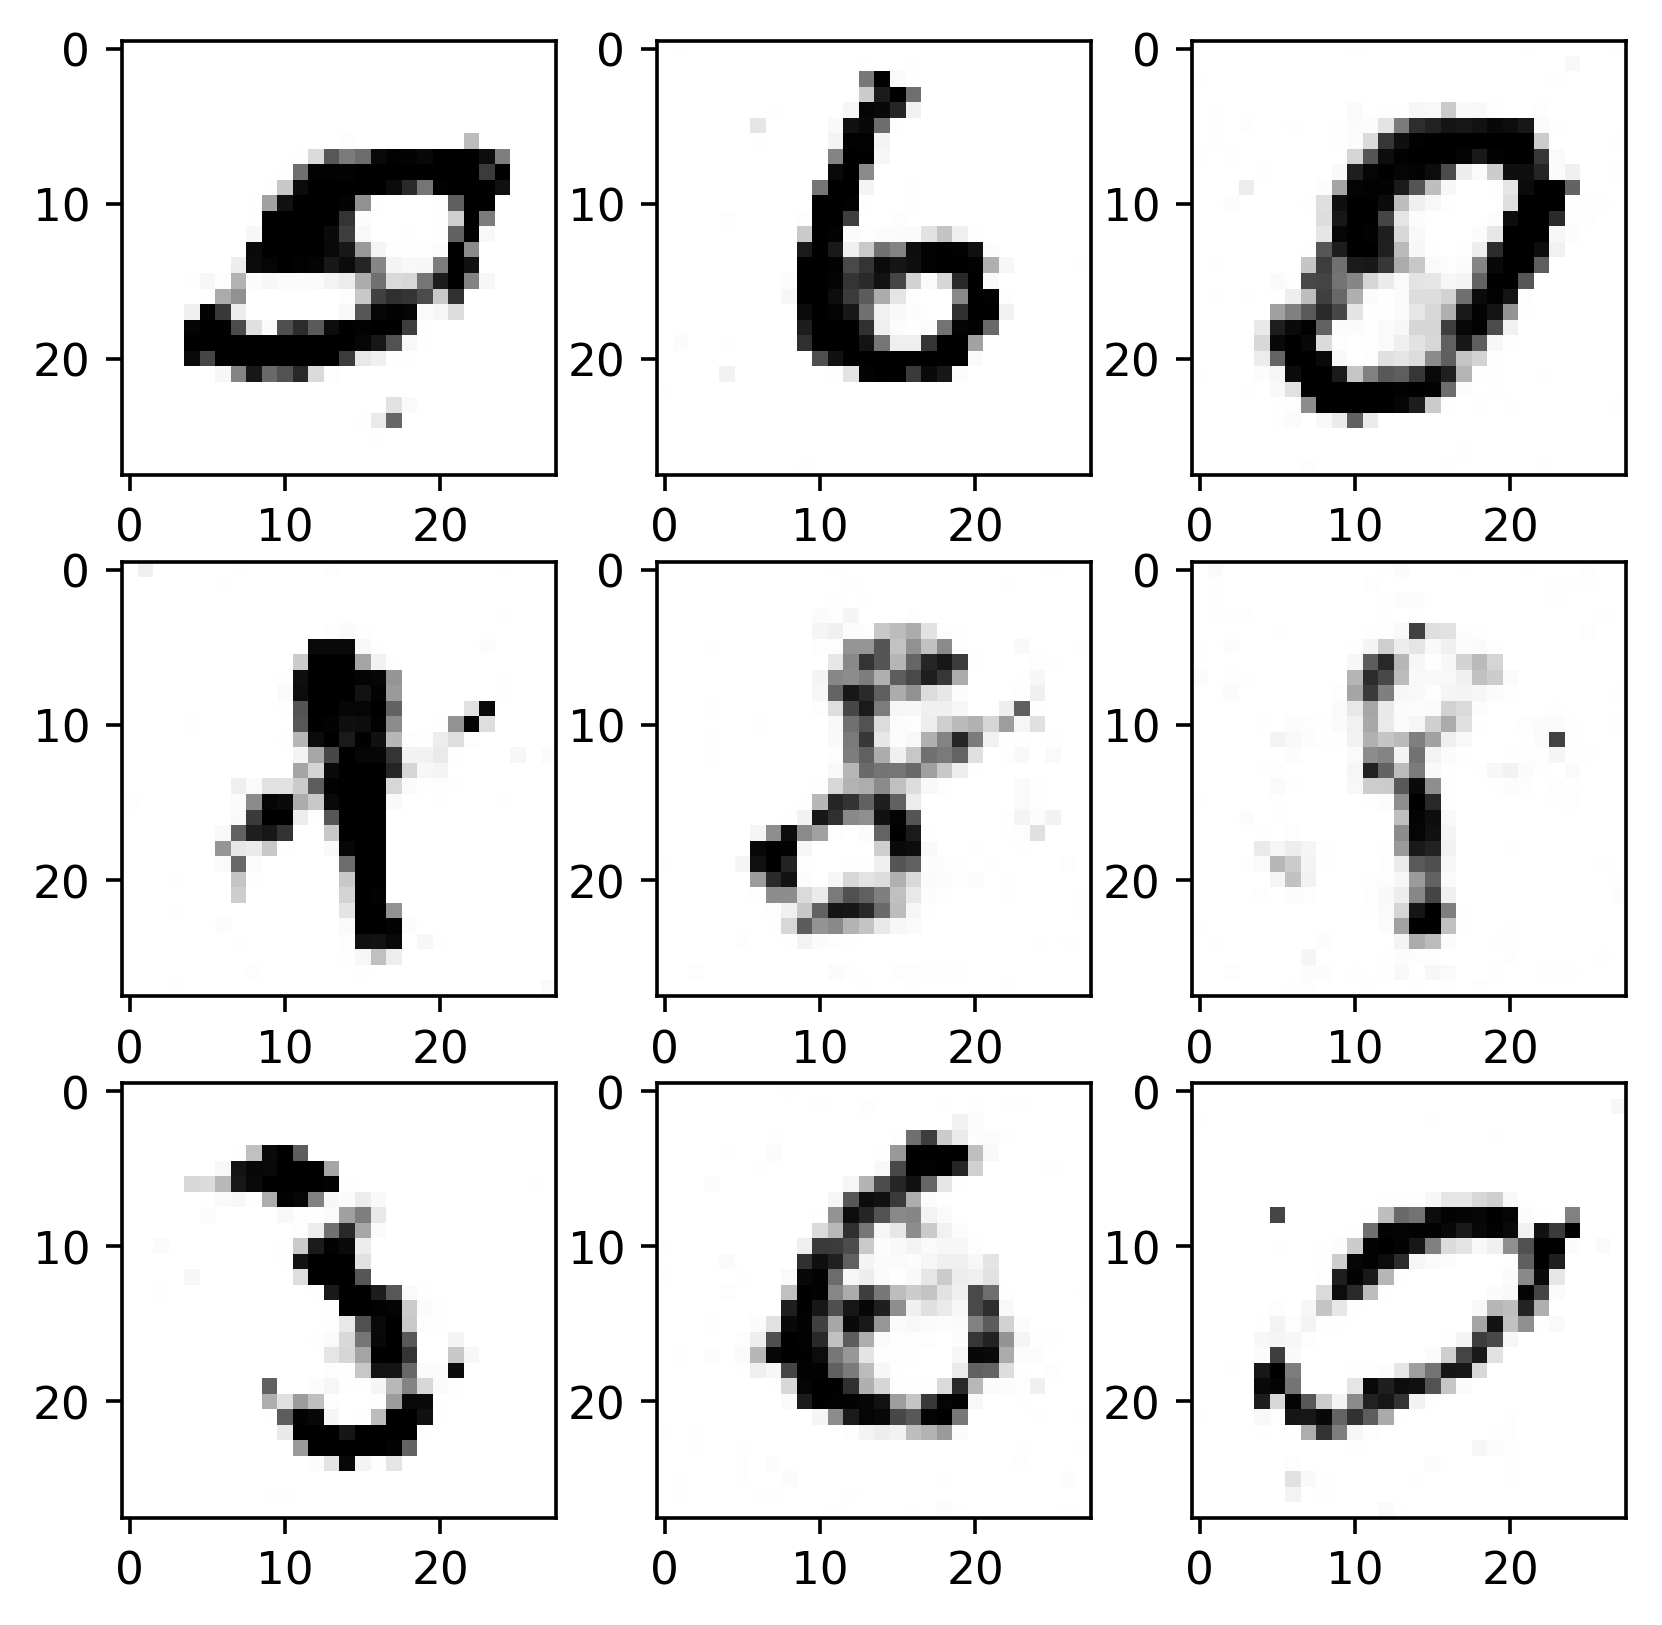

In [8]:
import matplotlib.pyplot as plt
import PIL
fig = plt.figure(figsize=(6, 6), dpi=326)
for i in range(3):
    for j in range(3):
        with torch.no_grad():
            ax = plt.subplot(3, 3, i * 3 + j + 1)
            noise = torch.randn(1, 100).cuda()
            fake_images = generator(noise)
            ax.imshow(fake_images.view(28, 28).cpu().numpy(), cmap="Greys")
plt.show()
plt.close("all")